## General information

This kernel is created using data of `Predicting Molecular Properties` competition.
We have information about atom couples in molecules and need to predict `scalar_coupling_constant` between these atoms.

![](http://www.et.byu.edu/~rowley/VLEfinal/methane_dimer.gif)

In this kernel I'll do EDA and will try some approaches to modelling.

*Work still in progress*


~Thanks to the new kaggle update we can write code in kernels and import it. This is much more convenient and useful. I'm moving all the functions I can into this script: https://www.kaggle.com/artgor/artgor-utils So if you see somewhere code like artgot_utils.function_name(parameters) - it is from this script~
I have realized that using utility scripts isn't very convenient, so I move all the code from that script into the notebook. But 

importing libraries

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')
import artgor_utils

# setting up altair
workaround = artgor_utils.prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

## Data loading and overview

In [2]:
os.listdir('../input/champs-scalar-coupling')

['potential_energy.csv',
 'mulliken_charges.csv',
 'train.csv',
 'scalar_coupling_contributions.csv',
 'sample_submission.csv',
 'structures',
 'test.csv',
 'magnetic_shielding_tensors.csv',
 'dipole_moments.csv',
 'structures.csv']

We have a lot of files, let's focus on the main ones for now.

In [3]:
train = pd.read_csv('../input/champs-scalar-coupling/train.csv')
test = pd.read_csv('../input/champs-scalar-coupling/test.csv')
sub = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')

In [4]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001


In [5]:
print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


So in out main data files we have information about moleculas and pairs of atoms
- test set in ~2 times smaller that train set;
- we have 28 unique atoms types and 8 coupling types;

In [6]:
train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147000000000e+06,4.658147000000000e+06,4.658147000000000e+06,4.658147000000000e+06
mean,2.329073000000000e+06,1.335688568866547e+01,5.883966306773917e+00,1.592164991825936e+01
std,1.344691356527209e+06,3.267712409449629e+00,4.993943098105586e+00,3.494197741570011e+01
min,0.000000000000000e+00,0.000000000000000e+00,0.000000000000000e+00,-3.621860000000000e+01
25%,1.164536500000000e+06,1.100000000000000e+01,2.000000000000000e+00,-2.549780000000000e-01
50%,2.329073000000000e+06,1.300000000000000e+01,5.000000000000000e+00,2.281130000000000e+00
75%,3.493609500000000e+06,1.600000000000000e+01,8.000000000000000e+00,7.390655000000000e+00
max,4.658146000000000e+06,2.800000000000000e+01,2.800000000000000e+01,2.048800000000000e+02


In [7]:
atom_count = train['atom_index_0'].value_counts().reset_index().rename(columns={'atom_index_0': 'count', 'index': 'atom_index_0'})
chart1 = alt.Chart(atom_count).mark_bar().encode(
    x=alt.X("atom_index_0:N", axis=alt.Axis(title='atom_index_0')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['atom_index_0', 'count']
).properties(title="Counts of atom_index_0", width=350).interactive()

atom_count = train['atom_index_1'].value_counts().reset_index().rename(columns={'atom_index_1': 'count', 'index': 'atom_index_1'})
chart2 = alt.Chart(atom_count).mark_bar().encode(
    x=alt.X("atom_index_1:N", axis=alt.Axis(title='atom_index_1')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['atom_index_1', 'count']
).properties(title="Counts of atom_index_1", width=350).interactive()

type_count = train['type'].value_counts().reset_index().rename(columns={'type': 'count', 'index': 'type'})
chart3 = alt.Chart(type_count).mark_bar().encode(
    x=alt.X("type:N", axis=alt.Axis(title='type')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['type', 'count']
).properties(title="Counts of type", width=350).interactive()

hist_df = pd.cut(train['scalar_coupling_constant'], 20).value_counts().sort_index().reset_index().rename(columns={'index': 'bins'})
hist_df['bins'] = hist_df['bins'].astype(str)
chart4 = alt.Chart(hist_df).mark_bar().encode(
    x=alt.X("bins:O", axis=alt.Axis(title='Target bins')),
    y=alt.Y('scalar_coupling_constant:Q', axis=alt.Axis(title='Count')),
    tooltip=['scalar_coupling_constant', 'bins']
).properties(title="scalar_coupling_constant histogram", width=400).interactive()


(chart1 | chart2) & (chart3 | chart4)

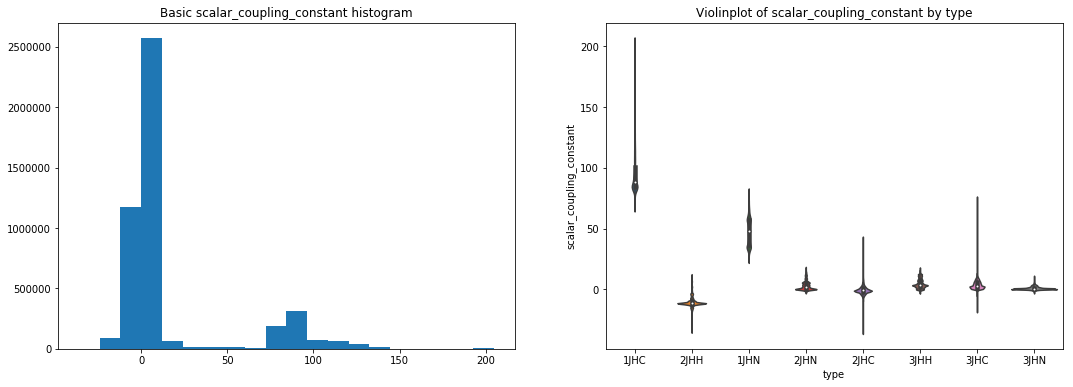

In [8]:
fig, ax = plt.subplots(figsize = (18, 6))
plt.subplot(1, 2, 1);
plt.hist(train['scalar_coupling_constant'], bins=20);
plt.title('Basic scalar_coupling_constant histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='scalar_coupling_constant', data=train);
plt.title('Violinplot of scalar_coupling_constant by type');

There are many interesting things here:
- among first atoms there is a little number of atoms with index lower than 7 or higher than 24;
- among second atoms there is a little number of atoms with index higher than 24. Also index with atom with index 9 in quite rare;
- coupling types are unevenly distributed. There are 3 very popular, 3 quite rare and 2 with medium frequency;
- target variable has a bimodal distribution;
- different coupling types have really different values of target variable. Maybe it would make sense to build separate models for each of them;

## Plotting network graphs by type

We have molecules, atom pairs, so this means data, which is interconnected. Network graphs should be useful to visualize such data!

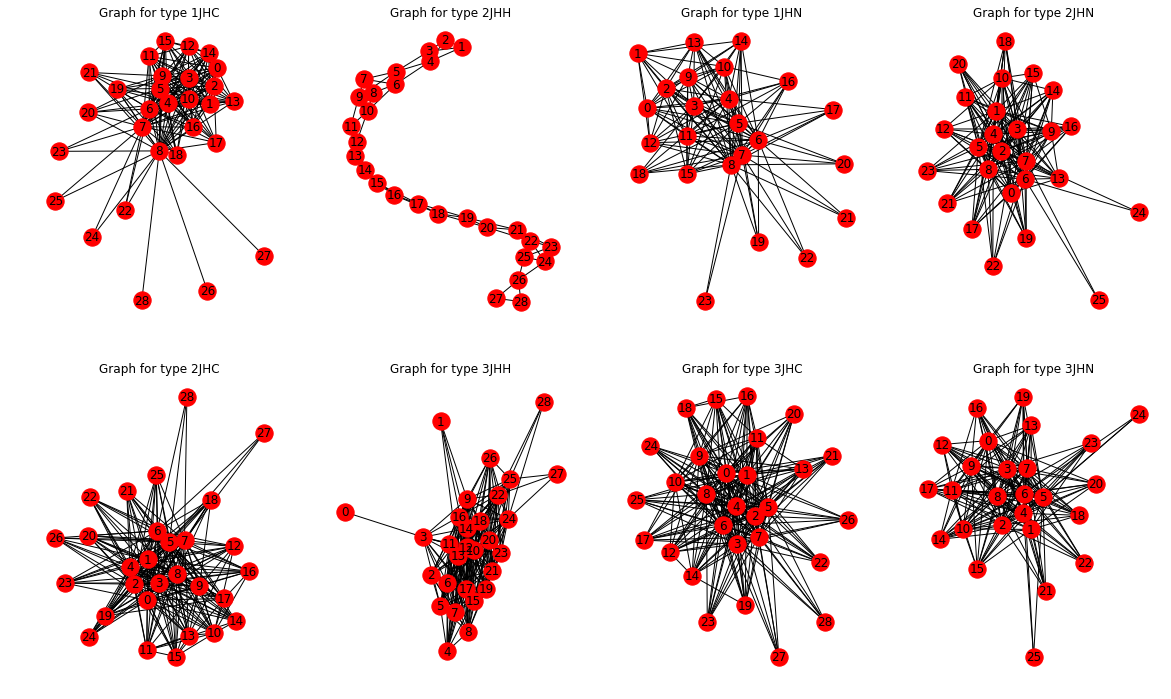

In [9]:
fig, ax = plt.subplots(figsize = (20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train.loc[train['type'] == t]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Graph for type {t}')

Cool! We can see that atom connections have different shapes for different types. Type 2JHH has an expecially unique scheme.
Also we can see that some atoms are connected only to several other atoms.

## Better network graphs
But there is a little problem: as we saw earlier, there are atoms which are very rare, as a result graphs will be skewed due to them. Now I'll drop atoms for each type which are present in less then 1% of connections

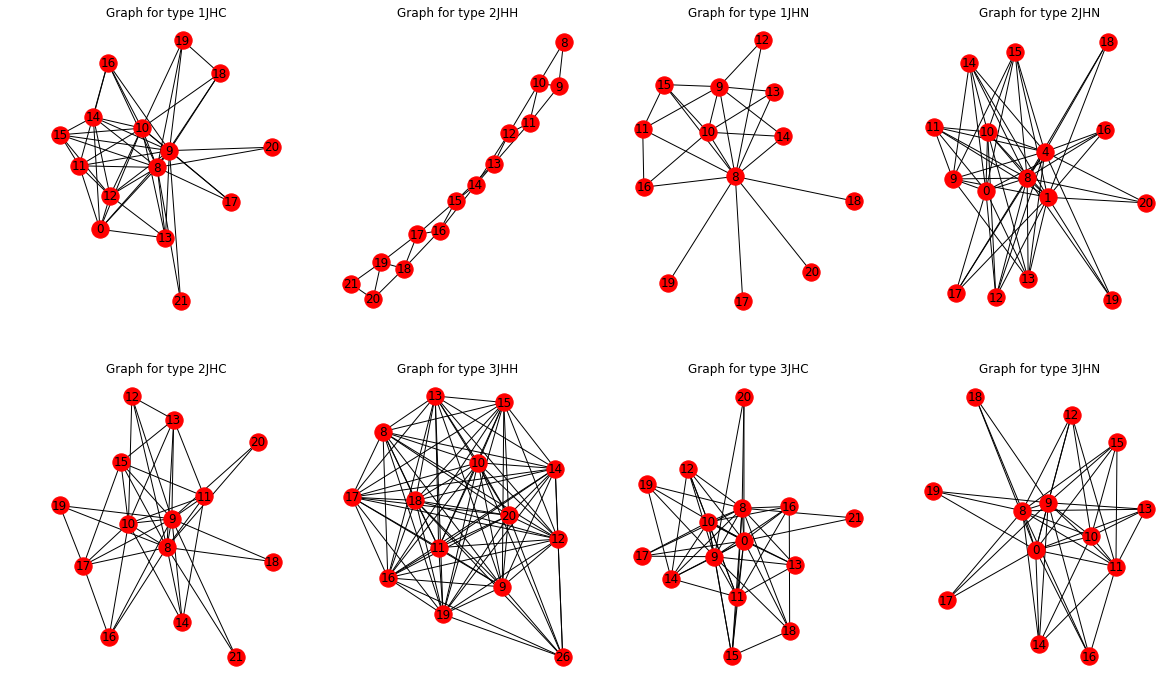

In [10]:
fig, ax = plt.subplots(figsize = (20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train.loc[train['type'] == t]
    bad_atoms_0 = list(train_type['atom_index_0'].value_counts(normalize=True)[train_type['atom_index_0'].value_counts(normalize=True) < 0.01].index)
    bad_atoms_1 = list(train_type['atom_index_1'].value_counts(normalize=True)[train_type['atom_index_1'].value_counts(normalize=True) < 0.01].index)
    bad_atoms = list(set(bad_atoms_0 + bad_atoms_1))
    train_type = train_type.loc[(train_type['atom_index_0'].isin(bad_atoms_0) == False) & (train_type['atom_index_1'].isin(bad_atoms_0) == False)]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Graph for type {t}')

Now the graphs are much more clear!

## Feature engineering

For now I'll use a basic approach to feature engineering.

I'll use this useful kernel:
https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

In [11]:
structures = pd.read_csv('../input/champs-scalar-coupling/structures.csv')

def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [12]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

I want to create two new features: one will show the first character of the `type`, the second one will show other characters.

In [13]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])
train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

So, everyone uses this distance feature, let's have a look at it!

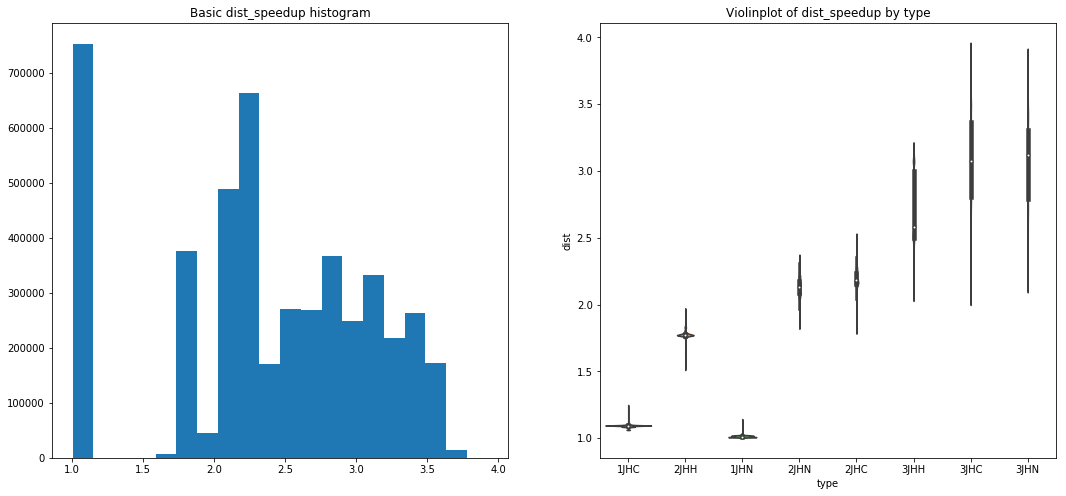

In [14]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.subplot(1, 2, 1);
plt.hist(train['dist'], bins=20);
plt.title('Basic dist_speedup histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='dist', data=train);
plt.title('Violinplot of dist_speedup by type');

It seems that the values are quite different for different types!

In [15]:
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

train['dist_to_type_0_mean'] = train['dist'] / train.groupby('type_0')['dist'].transform('mean')
test['dist_to_type_0_mean'] = test['dist'] / test.groupby('type_0')['dist'].transform('mean')

train['dist_to_type_1_mean'] = train['dist'] / train.groupby('type_1')['dist'].transform('mean')
test['dist_to_type_1_mean'] = test['dist'] / test.groupby('type_1')['dist'].transform('mean')

## Basic model

I'll use the function for metric calculation from this kernel: https://www.kaggle.com/abhishek/competition-metric

UPD: use faster metric from this kernel: https://www.kaggle.com/uberkinder/efficient-metric

You can see the code in my utility script. Please note that to use this metric for calculation you need to pass value `group_mae` to parameter `eval_metric`.

In [16]:
# train = pd.concat([train, pd.get_dummies(train['type'])], axis=1)
# test = pd.concat([test, pd.get_dummies(test['type'])], axis=1)

In [17]:
for f in ['atom_0', 'atom_1', 'type_0', 'type_1', 'type']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [18]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,type_1,dist_to_type_mean,dist_to_type_0_mean,dist_to_type_1_mean
0,0,dsgdb9nsd_000001,1,0,0,84.807599999999994,0,0.002150416,-0.0060313176,0.0019761204,0,-0.0126981359,1.085804158,0.0080009958,1.091953059611900,0.000220479493527,1.192104705778678,0.000036299123586,0,0,0.999133993514757,1.003366595134415,0.463061408177816
1,1,dsgdb9nsd_000001,1,2,3,-11.257000000000000,0,0.002150416,-0.0060313176,0.0019761204,1,1.0117308430,1.463751162,0.0002765748,1.783119756038801,1.019252638581502,2.160260537339124,0.000002888455246,1,1,1.004633785679569,0.852949262177106,0.761935207514872
2,2,dsgdb9nsd_000001,1,3,3,-11.254799999999999,0,0.002150416,-0.0060313176,0.0019761204,1,-0.5408150690,1.447526614,-0.8766437152,1.783147496403011,0.294811517901285,2.112830660517270,0.771972815509771,1,1,1.004649414975929,0.852962531685845,0.761947061099068
3,3,dsgdb9nsd_000001,1,4,3,-11.254300000000001,0,0.002150416,-0.0060313176,0.0019761204,1,-0.5238136345,1.437932644,0.9063972942,1.783156685329616,0.276638182418367,2.085031922399566,0.817977659617770,1,1,1.004654592141451,0.852966927177590,0.761950987569333
4,4,dsgdb9nsd_000001,2,0,0,84.807400000000001,0,1.011730843,1.4637511620,0.0002765748,0,-0.0126981359,1.085804158,0.0080009958,1.091951618581363,1.049454732810097,0.142843937832576,0.000059666679785,0,0,0.999132674975848,1.003365271009819,0.463060797084121


In [19]:
X = train.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)
y = train['scalar_coupling_constant']
X_test = test.drop(['id', 'molecule_name'], axis=1)

In [20]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Fold 1 started at Sat Jun  1 05:09:53 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.82525	valid_1's l1: 1.92372
[2000]	training's l1: 1.68129	valid_1's l1: 1.85412
[3000]	training's l1: 1.58242	valid_1's l1: 1.81742
[4000]	training's l1: 1.50291	valid_1's l1: 1.79378
[5000]	training's l1: 1.43514	valid_1's l1: 1.77541
[6000]	training's l1: 1.37675	valid_1's l1: 1.76224
[7000]	training's l1: 1.32428	valid_1's l1: 1.75135
[8000]	training's l1: 1.27625	valid_1's l1: 1.74212
[9000]	training's l1: 1.23236	valid_1's l1: 1.73444
[10000]	training's l1: 1.19175	valid_1's l1: 1.72811
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 1.19175	valid_1's l1: 1.72811
Fold 2 started at Sat Jun  1 06:31:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.82277	valid_1's l1: 1.92286
[2000]	training's l1: 1.68054	valid_1's l1: 1.85367
[3000]	training's l1: 1.58171	valid_1's l1: 1.81749
[4000]	tra

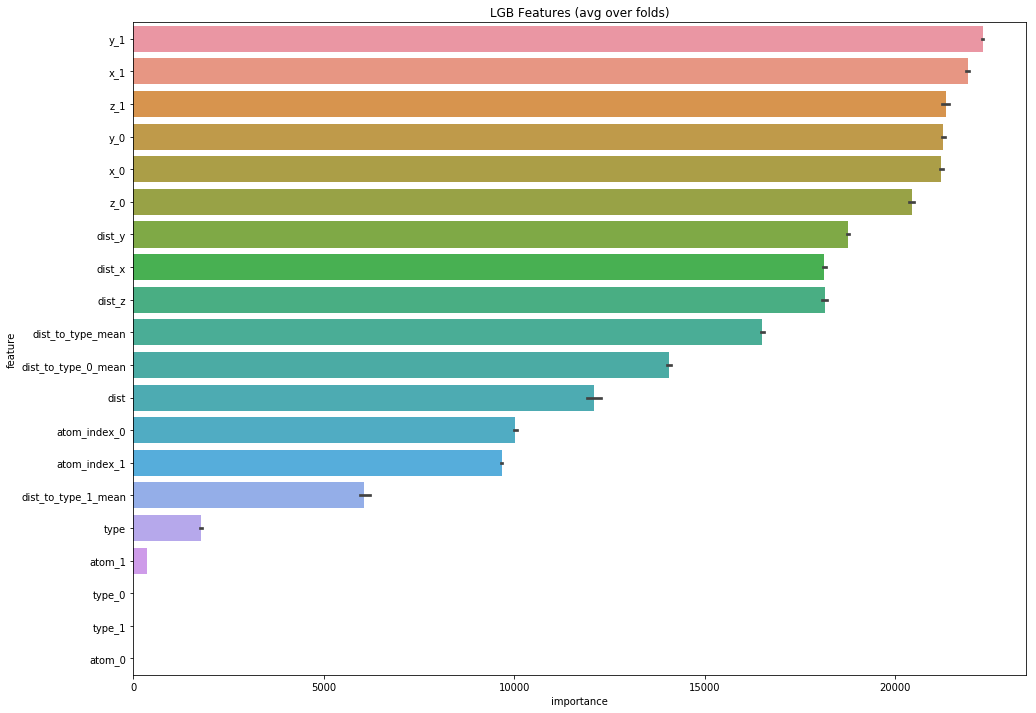

In [21]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=1000, early_stopping_rounds=200, n_estimators=10000)


In [22]:
sub['scalar_coupling_constant'] = result_dict_lgb['prediction']
sub.to_csv('submission.csv', index=False)
sub.head()

,id,scalar_coupling_constant
0,4658147,8.516944031921852
1,4658148,196.592144106360081
2,4658149,5.043151684563132
3,4658150,195.924160431047255
4,4658151,7.704662597876752


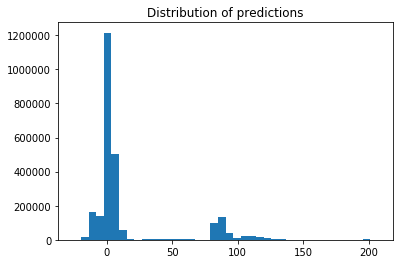

In [23]:
plt.hist(result_dict_lgb['prediction'], bins=40);
plt.title('Distribution of predictions');

## Plot oof predictions vs target

I use the code from benchmark kernel: https://www.kaggle.com/inversion/atomic-distance-benchmark

Notice that while using `LabelEncoder` on categorical variables, `type` was the last feature, so `lbl` contains encodings for it and we can inverse_transform `type`.

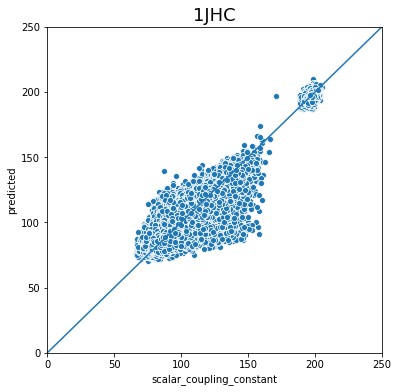

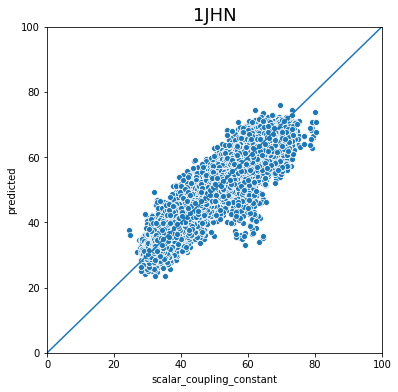

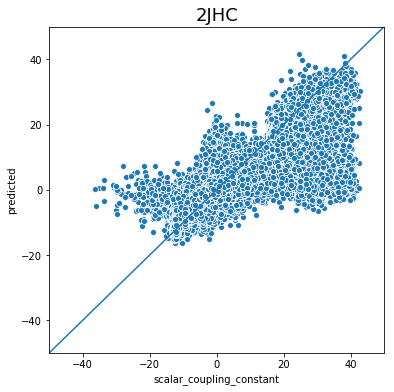

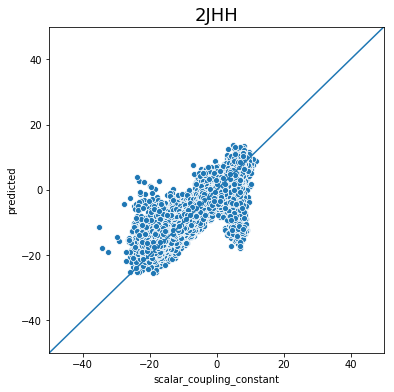

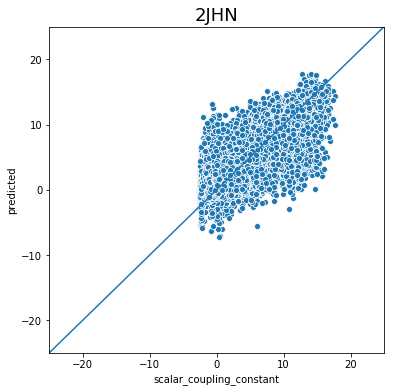

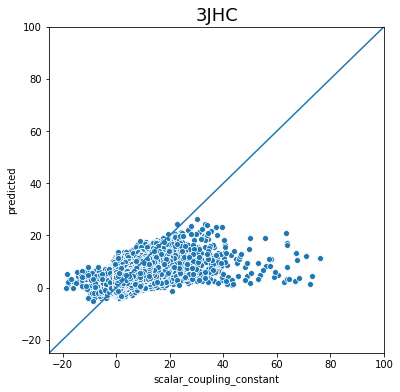

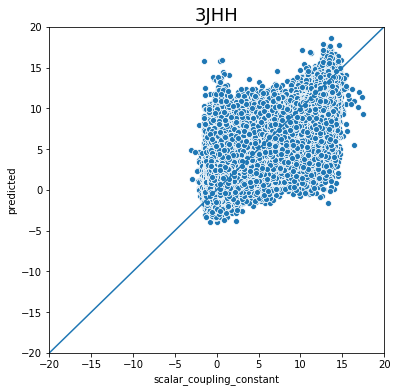

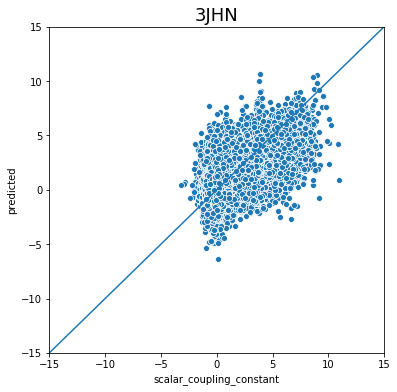

In [24]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict_lgb['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)

We can see that some types has better predictions than others. Maybe we should focus on improving models for these types?